In [6]:
import lilio
import numpy as np
import sys
import time as tt
import urllib
import xarray as xr
from s2spy import preprocess
import torch
from torch import nn
from pathlib import Path

In [7]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="08-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="30d")
# add precursor periods
periods_of_interest = 4
calendar.add_intervals("precursor", "1M", gap="1M", n=periods_of_interest)

In [8]:
def load_data(url, field, var):
    '''Download a netCDF file from a URL and open a variable as xr.DataArray.'''
    url_field = url + field
    urllib.request.urlretrieve(url_field, field)
    dataset = xr.open_dataset(field)
    dataarray = dataset[var]
    return dataarray 

In [9]:
# URL of the dataset from zenodo
url = "https://zenodo.org/record/8186914/files/"

sst_field = "sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc" # Pacific Ocean SST
t2m_field = "t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc" # Southwestern USA T2M

In [10]:
precursor_field = load_data(url, sst_field, "sst")
target_field = load_data(url, t2m_field, "t2m").sel(cluster=3)

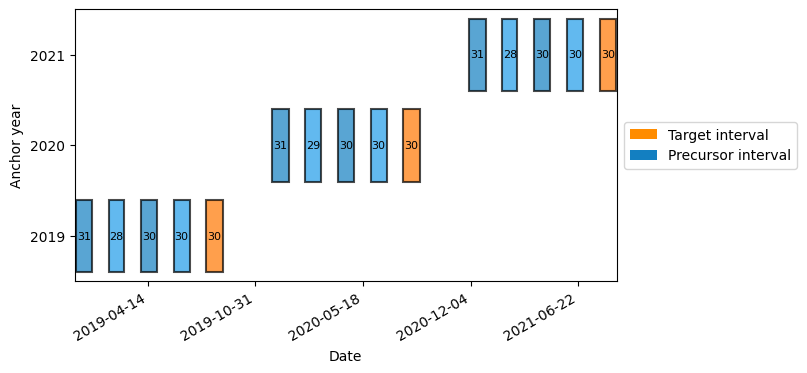

In [11]:
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

In [12]:
# get 60% of instance as training
years = sorted(calendar.get_intervals().index)
train_samples = round(len(years) * 0.6)
test_samples = round(len(years) * 0.2)
start_year = years[0]

print(train_samples, test_samples)

37 12


In [13]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    timescale="monthly",
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(
    precursor_field.sel(
        time=slice(str(start_year), str(start_year + train_samples - 1))
    )
)

/Users/clairedonnelly/AI4S2S/.venv/lib/python3.10/site-packages/s2spy/preprocess.py:155: UserWarning: The temporal resolution of data does not completely match the target timescale. Please check your input data.
  warnings.warn(


In [14]:
# preprocess the whole precursor field
precursor_field_prep = preprocessor.transform(precursor_field)

In [15]:
precursor_field_resample = lilio.resample(calendar, precursor_field_prep)
target_field_resample = lilio.resample(calendar, target_field)

In [16]:
# slice and reshape input desired by transformer
sequence_precursor = len(precursor_field_resample.i_interval) - 1 # we only take precursor parts of i intervals
lat_precursor = len(precursor_field_resample.latitude)
lon_precursor = len(precursor_field_resample.longitude)

X_torch = torch.from_numpy(precursor_field_resample[:,:-1,:,:].data).type(torch.FloatTensor)
y_torch = torch.from_numpy(target_field_resample[:,-1].data).type(torch.FloatTensor)

X_torch = X_torch.view(-1, sequence_precursor, lat_precursor*lon_precursor)
y_torch = y_torch.unsqueeze(1).unsqueeze(1).repeat(1, 1, lat_precursor*lon_precursor)

# turn nan to 0.0
X_torch = torch.nan_to_num(X_torch, 0.0)

In [17]:
# train/validate/test split and use pytorch dataloader
train_X_torch = X_torch[:train_samples]
train_y_torch = y_torch[:train_samples]

valid_X_torch = X_torch[train_samples:train_samples + test_samples]
valid_y_torch = y_torch[train_samples:train_samples + test_samples]

test_X_torch = X_torch[-test_samples:]
test_y_torch = y_torch[-test_samples:]

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch, train_y_torch)
valid_set = torch.utils.data.TensorDataset(valid_X_torch, valid_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch, test_y_torch)